# Imports set up rendering

In [73]:
#@title Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=osmesa
os.environ['MUJOCO_GL'] = 'osmesa'

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true "
    "--xla_gpu_triton_gemm_any=True "
    # "--xla_gpu_enable_async_collectives=true "
    # "--xla_gpu_enable_latency_hiding_scheduler=true "
    # "--xla_gpu_enable_highest_priority_async_stream=true "
)
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.90"


Sun Sep 22 22:25:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:1A:00.0 Off |                  N/A |
| 41%   38C    P8              34W / 280W |  22068MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
%load_ext autoreload
%autoreload 2
import functools
import os
import pickle
import warnings
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Text, Tuple, Union

import imageio
import jax
import mediapy as media
import mujoco
import numpy as np
import PIL.ImageDraw
import wandb
import yaml
from brax import base, envs, math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax import struct
from IPython.display import HTML
from jax import numpy as jp
from matplotlib import pyplot as plt
from ml_collections import config_dict
from mujoco import mjx
import jax
from jax import numpy as jp

from brax.io import mjcf as mjcf_brax
from brax import math as brax_math



# from brax.training.agents.ppo import train as ppo
import custom_brax.custom_ppo as ppo
import custom_brax.custom_wrappers as custom_wrappers
from preprocessing.preprocess import process_clip_to_train
from envs.fruitfly import Fruitfly_Tethered
from utils.utils import *

warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-09-22 22:25:54.614930: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
from absl import app, flags

FLAGS = flags.FLAGS

n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")

flags.DEFINE_enum("solver", "cg", ["cg", "newton"], "constraint solver")
flags.DEFINE_integer("iterations", 4, "number of solver iterations")
flags.DEFINE_integer("ls_iterations", 4, "number of linesearch iterations")

Using 2 GPUs


# Load configs

In [10]:
dataset = 'Flybody'
version = 'debug'
# version = 'partial_obs'
base_dir = Path(f'/data/users/eabe/biomech_model/{dataset}/RL_{dataset}/{version}')
configs = sorted(list(base_dir.rglob('*config.yaml'))[::2])
fig_path = Path('/data/users/eabe/hypernets/SLDS/TiDHy_SLDS/r2_orth_long/Paper_Figs')
for n,conf in enumerate(configs):
    print(n,conf)


n = 0
cfg_path =configs[n]
cfg = load_cfg(cfg_path)

0 /data/users/eabe/biomech_model/Flybody/RL_Flybody/debug/config.yaml


In [11]:
for k in cfg.paths.keys():
    if k != 'user':
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
env_cfg = cfg.dataset
env_args = cfg.dataset.env_args
reference_path = cfg.paths.data_dir/ f"clips/{env_cfg['clip_idx']}.p"
reference_path.parent.mkdir(parents=True, exist_ok=True)

if os.path.exists(reference_path):
    with open(reference_path, "rb") as file:
        # Use pickle.load() to load the data from the file
        reference_clip = pickle.load(file)
else:
    # Process rodent clip and save as pickle
    reference_clip = process_clip_to_train(
        env_cfg["stac_path"],
        start_step=env_cfg["clip_idx"] * env_args["clip_length"],
        clip_length=env_args["clip_length"],
        mjcf_path=env_args["mjcf_path"],
    )
    with open(reference_path, "wb") as file:
        # Use pickle.dump() to save the data to the file
        pickle.dump(reference_clip, file)

In [24]:

class Fruitfly_Tethered(PipelineEnv):

    def __init__(
        self,
        reference_clip,
        center_of_mass: str,
        end_eff_names: List[str],
        appendage_names: List[str],
        body_names: List[str],
        joint_names: List[str],
        mocap_hz: int = 50,
        mjcf_path: str = "./assets/fruitfly/fruitfly_force_free.xml",
        scale_factor: float = 0.9,
        torque_actuators: bool = False,
        ref_len: int = 5,
        too_far_dist=0.1,
        bad_pose_dist=jp.inf,
        bad_quat_dist=jp.inf,
        ctrl_cost_weight=0.01,
        pos_reward_weight=0.0,
        quat_reward_weight=1.0,
        joint_reward_weight=10.0,
        angvel_reward_weight=1.0,
        bodypos_reward_weight=1.0,
        endeff_reward_weight=1.0,
        healthy_reward=0.25,
        healthy_z_range=(0.03, 0.5),
        physics_steps_per_control_step=10,
        reset_noise_scale=1e-3,
        solver="cg",
        iterations: int = 6,
        ls_iterations: int = 6,
        terminate_when_unhealthy=True,
        **kwargs,
    ):
        root = mujoco.MjModel.from_xml_path(mjcf_path)

        # Convert to torque actuators
        if torque_actuators:
            for actuator in root.find_all("actuator"):
                actuator.gainprm = [actuator.forcerange[1]]
                del actuator.biastype
                del actuator.biasprm
                
        mj_model = root
        mj_model.opt.solver = {
            "cg": mujoco.mjtSolver.mjSOL_CG,
            "newton": mujoco.mjtSolver.mjSOL_NEWTON,
        }[solver.lower()]
        mj_model.opt.iterations = iterations
        mj_model.opt.ls_iterations = ls_iterations

        mj_model.opt.jacobian = 0
        
        sys = mjcf_brax.load_model(mj_model)

        kwargs["n_frames"] = kwargs.get("n_frames", physics_steps_per_control_step)
        kwargs["backend"] = "mjx"
        
        max_physics_steps_per_control_step = int((1.0 / (mocap_hz * mj_model.opt.timestep)))

        super().__init__(sys, **kwargs)
        if max_physics_steps_per_control_step % physics_steps_per_control_step != 0:
            raise ValueError(f"physics_steps_per_control_step ({physics_steps_per_control_step}) must be a factor of ({max_physics_steps_per_control_step})")

        self._steps_for_cur_frame = (max_physics_steps_per_control_step / physics_steps_per_control_step)
        
        print(f"self._steps_for_cur_frame: {self._steps_for_cur_frame}")

        self._thorax_idx = mujoco.mj_name2id(mj_model, mujoco.mju_str2Type("body"), center_of_mass)

        self._joint_idxs = jp.array([mujoco.mj_name2id(mj_model, mujoco.mju_str2Type("joint"), joint) for joint in joint_names])

        self._body_idxs = jp.array([mujoco.mj_name2id(mj_model, mujoco.mju_str2Type("body"), body) for body in body_names])

        # using this for appendage for now bc im to lazy to rename 
        self._endeff_idxs = jp.array([mujoco.mj_name2id(mj_model, mujoco.mju_str2Type("body"), body) for body in end_eff_names])

        self._mocap_hz = mocap_hz
        self._bad_pose_dist = bad_pose_dist
        self._too_far_dist = too_far_dist
        self._bad_quat_dist = bad_quat_dist
        self._ref_traj = reference_clip
        self._ref_len = ref_len
        self._pos_reward_weight = pos_reward_weight
        self._quat_reward_weight = quat_reward_weight
        self._joint_reward_weight = joint_reward_weight
        self._angvel_reward_weight = angvel_reward_weight
        self._bodypos_reward_weight = bodypos_reward_weight
        self._endeff_reward_weight = endeff_reward_weight
        self._ctrl_cost_weight = ctrl_cost_weight
        self._healthy_reward = healthy_reward
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        self._terminate_when_unhealthy = terminate_when_unhealthy

    def reset(self, rng) -> State:
        """Resets the environment to an initial state."""
        rng, rng1, rng2, rng_pos = jax.random.split(rng, 4)

        start_frame = jax.random.randint(rng, (), 0, 44)

        info = {
            "start_frame": start_frame,
            "summed_pos_distance": 0.0,
            "quat_distance": 0.0,
            "joint_distance": 0.0,
        }

        low, hi = -self._reset_noise_scale, self._reset_noise_scale

        # Add pos (without z height)
        new_qpos = jp.array(self.sys.qpos0)


        # Add quat
        # new_qpos = qpos_with_pos.at[3:7].set(self._track_quat[start_frame])

        # Add noise
        qpos = new_qpos + jax.random.uniform(rng1, (self.sys.nq,), minval=low, maxval=hi)
        qvel = jax.random.uniform(rng2, (self.sys.nv,), minval=low, maxval=hi)

        data = self.pipeline_init(qpos, qvel)

        obs = self._get_obs(data, start_frame)
        reward, done, zero = jp.zeros(3)
        metrics = {
            "pos_reward": zero,
            "quat_reward": zero,
            "joint_reward": zero,
            "angvel_reward": zero,
            "bodypos_reward": zero,
            "endeff_reward": zero,
            "reward_quadctrl": zero,
            "reward_alive": zero,
            "too_far": zero,
            "bad_pose": zero,
            "bad_quat": zero,
            "fall": zero,
        }
        return State(data, obs, reward, done, metrics, info)

    def step(self, state: State, action: jp.ndarray) -> State:
        """Runs one timestep of the environment's dynamics."""
        data0 = state.pipeline_state
        data = self.pipeline_step(data0, action)

        info = state.info.copy()
        
        # Logic for getting current frame aligned with simulation time
        cur_frame = (info["start_frame"] + (data.time // (1 / self._mocap_hz))).astype(int)
        if self._ref_traj.position is not None:
            track_pos = self._ref_traj.position
            pos_distance = data.qpos[:3] - track_pos[cur_frame]
            pos_reward = self._pos_reward_weight * jp.exp(-400 * jp.sum(pos_distance) ** 2)
            track_quat = self._ref_traj.quaternion
            quat_distance = jp.sum(self._bounded_quat_dist(data.qpos[3:7], track_quat[cur_frame])** 2)
            quat_reward = self._quat_reward_weight * jp.exp(-4.0 * quat_distance)
        else: 
            pos_distance = jp.zeros(3)
            quat_distance = 0.0
            pos_reward = 0.0
            quat_reward = 0.0

        track_joints = self._ref_traj.joints
        joint_distance = (jp.sum(data.qpos - track_joints[cur_frame]) ** 2)
        joint_reward = self._joint_reward_weight * jp.exp(-0.5 * joint_distance)
        info["joint_distance"] = joint_distance

        track_angvel = self._ref_traj.angular_velocity
        angvel_reward = self._angvel_reward_weight * jp.exp(-0.5 * jp.sum(data.qvel[3:6] - track_angvel[cur_frame]) ** 2)
        track_bodypos = self._ref_traj.body_positions
        bodypos_reward = self._bodypos_reward_weight * jp.exp(-6.0 * jp.sum((data.xpos[self._body_idxs] - track_bodypos[cur_frame][self._body_idxs]).flatten())** 2)

        endeff_reward = self._endeff_reward_weight * jp.exp(-0.75* jp.sum((data.xpos[self._endeff_idxs]- track_bodypos[cur_frame][self._endeff_idxs]).flatten())** 2)

        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(data.xpos[self._thorax_idx][2] < min_z, 0.0, 1.0)
        is_healthy = jp.where(data.xpos[self._thorax_idx][2] > max_z, 0.0, is_healthy)
        if self._terminate_when_unhealthy:
            healthy_reward = self._healthy_reward
        else:
            healthy_reward = self._healthy_reward * is_healthy
        summed_pos_distance = jp.sum((pos_distance * jp.array([1.0, 1.0, 0.2])) ** 2)
        too_far = jp.where(summed_pos_distance > self._too_far_dist, 1.0, 0.0)
        info["summed_pos_distance"] = summed_pos_distance
        info["quat_distance"] = quat_distance
        bad_pose = jp.where(joint_distance > self._bad_pose_dist, 1.0, 0.0)
        bad_quat = jp.where(quat_distance > self._bad_quat_dist, 1.0, 0.0)
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

        obs = self._get_obs(data, cur_frame)
        reward = (
            joint_reward
            + pos_reward
            + quat_reward
            + angvel_reward
            + bodypos_reward
            + endeff_reward
            + healthy_reward
            - ctrl_cost
        )
        done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
        done = jp.max(jp.array([done, too_far, bad_pose, bad_quat]))

        # Handle nans during sim by resetting env
        reward = jp.nan_to_num(reward)
        obs = jp.nan_to_num(obs)

        from jax.flatten_util import ravel_pytree

        flattened_vals, _ = ravel_pytree(data)
        num_nans = jp.sum(jp.isnan(flattened_vals))
        nan = jp.where(num_nans > 0, 1.0, 0.0)
        done = jp.max(jp.array([nan, done]))

        state.metrics.update(
            pos_reward=pos_reward,
            quat_reward=quat_reward,
            joint_reward=joint_reward,
            angvel_reward=angvel_reward,
            bodypos_reward=bodypos_reward,
            endeff_reward=endeff_reward,
            reward_quadctrl=-ctrl_cost,
            reward_alive=healthy_reward,
            too_far=too_far,
            bad_pose=bad_pose,
            bad_quat=bad_quat,
            fall=1 - is_healthy,
        )

        return state.replace(
            pipeline_state=data, obs=obs, reward=reward, done=done, info=info
        )

    def _get_obs(self, data: mjx.Data, cur_frame: int) -> jp.ndarray:
        """Observes rodent body position, velocities, and angles."""
        
        # Get the relevant slice of the ref_traj
        def f(x):
            if len(x.shape) != 1:
                return jax.lax.dynamic_slice_in_dim(
                    x,
                    cur_frame + 1,
                    self._ref_len,
                )
            return jp.array([])

        ref_traj = jax.tree_util.tree_map(f, self._ref_traj)
        
        # track_pos_local = jax.vmap(
        #     lambda a, b: brax_math.rotate(a, b), in_axes=(0, None)
        # )(
        #     ref_traj.position - data.qpos[:3],
        #     data.qpos[3:7],
        # ).flatten()

        # quat_dist = jax.vmap(
        #     lambda a, b: brax_math.relative_quat(a, b), in_axes=(None, 0)
        # )(
        #     data.qpos[3:7],
        #     ref_traj.quaternion,
        # ).flatten()

        joint_dist = (ref_traj.joints - data.qpos)[:, self._joint_idxs].flatten()

        # TODO test if this works
        body_pos_dist_local = jax.vmap(
            lambda a, b: jax.vmap(brax_math.rotate, in_axes=(0, None))(a, b),
            in_axes=(0, None),)((ref_traj.body_positions - data.xpos)[:, self._body_idxs],data.qpos[3:7],).flatten()

        return jp.concatenate(
            [
                data.qpos,
                data.qvel,
                # data.cinert[1:].ravel(),
                # data.cvel[1:].ravel(),
                # data.qfrc_actuator,
                # track_pos_local,
                # quat_dist,
                joint_dist,
                body_pos_dist_local,
            ]
        )

    def _bounded_quat_dist(self, source: np.ndarray, target: np.ndarray) -> np.ndarray:
        """Computes a quaternion distance limiting the difference to a max of pi/2.

        This function supports an arbitrary number of batch dimensions, B.

        Args:
          source: a quaternion, shape (B, 4).
          target: another quaternion, shape (B, 4).

        Returns:
          Quaternion distance, shape (B, 1).
        """
        source /= jp.linalg.norm(source, axis=-1, keepdims=True)
        target /= jp.linalg.norm(target, axis=-1, keepdims=True)
        # "Distance" in interval [-1, 1].
        dist = 2 * jp.einsum("...i,...i", source, target) ** 2 - 1
        # Clip at 1 to avoid occasional machine epsilon leak beyond 1.
        dist = jp.minimum(1.0, dist)
        # Divide by 2 and add an axis to ensure consistency with expected return
        # shape and magnitude.
        return 0.5 * jp.arccos(dist)[..., np.newaxis]
    

In [25]:
envs.register_environment("fly_single_clip", Fruitfly_Tethered)


In [26]:
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **env_args,
)

self._steps_for_cur_frame: 2.0


In [27]:
rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)


'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco

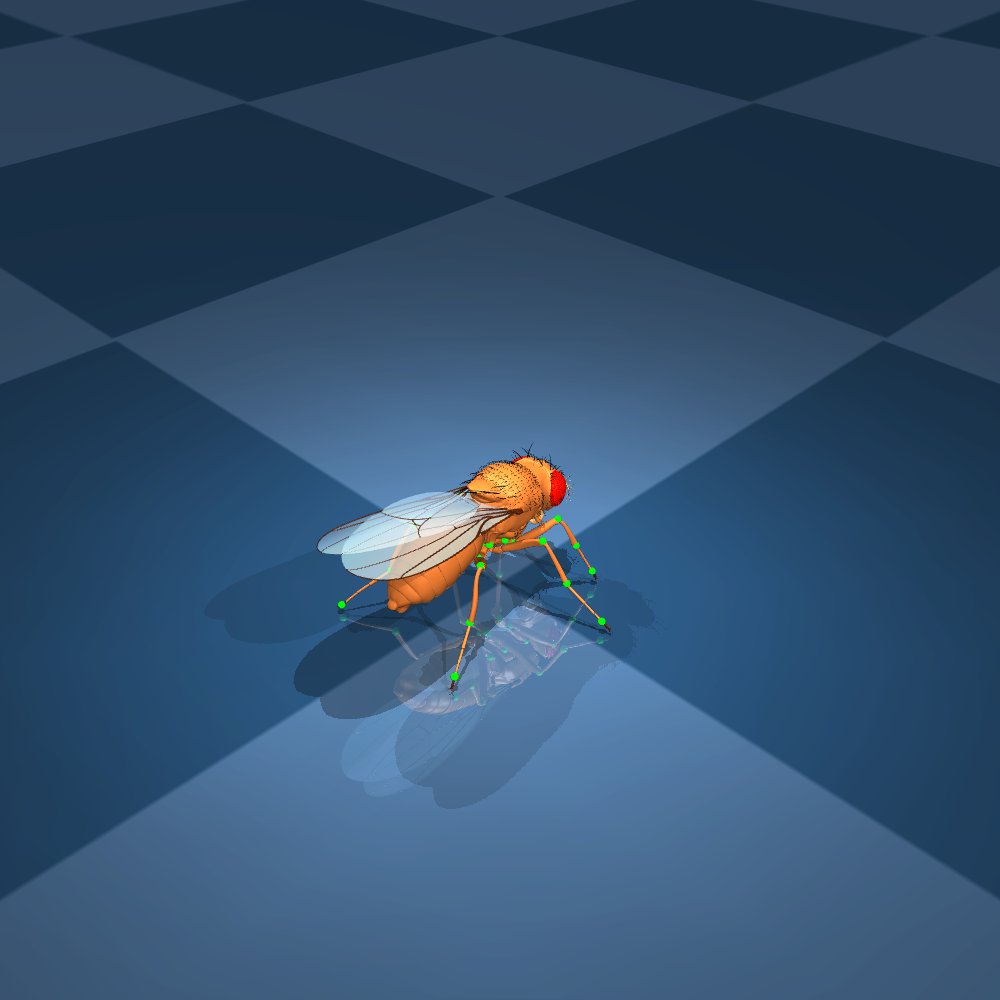

In [30]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(100):
    ctrl = 0.5*jp.ones(env.sys.nu)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

pixels = env.render(rollout, width=1000, height=1000, camera=3) 
PIL.Image.fromarray(pixels[2])

In [31]:
media.show_video(env.render(rollout, width=640, height=480, camera=1), fps=1 / env.dt)

'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco

gnized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this t

# Viz

'./assets/fruitfly/fruitfly_force.xml'

'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco

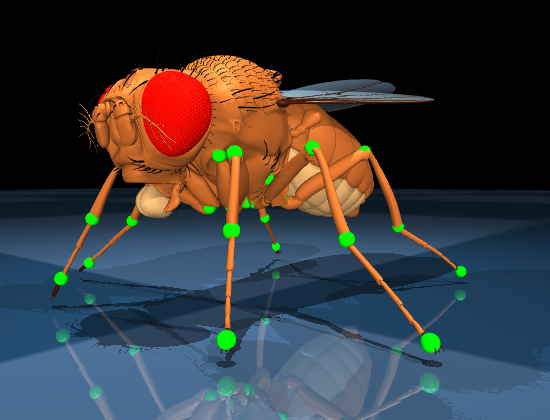

In [11]:
# xml_path = task_path / 'task_viz.xml'
# xml_path = task_path.parent / 'fruitfly_force_pair.xml'
# xml_path = task_path.parent / 'fruitfly_force_seq.xml'
# xml_path = task_path.parent / 'fruitfly_freeforce.xml'

mj_model = mujoco.MjModel.from_xml_path(cfg.dataset.env_args.mjcf_path)

mj_data = mujoco.MjData(mj_model)

mocap_names = [mj_model.site(i).name for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
mocap_id = [mj_model.site(i).id for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
site_names = [mj_model.site(i).name for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
site_id = [mj_model.site(i).id for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
# for id in mocap_id:
#     mj_model.site(id).rgba = [0,1,0,1]
# for id in site_id:
#     mj_model.site(id).rgba = [1,0,0,1]

# geom_names = [mj_model.geom(i).name for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]
# geom_ids = [mj_model.geom(i).id for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]

# for id in geom_ids[5:]:
#     mj_model.geom(id).group = 4

camera_id = 0

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 0, 1, 0]
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_FOG] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_STATIC] = False

# mj_data.qpos = np.concatenate([qposes_stac[n] for n in range(0,2)])
# mj_data.qpos = qposes_stac[0]
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=420, width=550)


# mj_data.mocap_pos = mod_frames[0].copy()
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera=camera_id, scene_option=scene_option)
pixels = renderer.render()
PIL.Image.fromarray(pixels)
# im = PIL.Image.fromarray(pixels)
# im.save(fig_path/'init_camera{}.png'.format(camera_id),format='png')